In [44]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import json
from pandas.io.json import json_normalize
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
import seaborn as sns
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import gls
import matplotlib.pyplot as plt

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

**Austrian banking system

In [2]:
austria = pd.read_csv(r'C:\Users\WZHKLB\Desktop\Personal\Python\Springboard projects\Capstone 1\AT_clean.csv')

In [3]:
austria.describe()

,INFL,DEP,LOA,UNE,GDP,NUM,CAR,T1,NPL,NIM,ROA,ROE,LA,LATA
count,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.00000,40.00000
mean,109.751638,28.675000,27.900000,5.22550,106.622698,42.587500,16.966000,13.453250,2.756000,61.102000,0.276000,4.13100,70.43450,24.74050
std,5.494802,0.729858,3.287895,0.46138,4.620427,3.349584,1.034933,1.418514,0.625836,2.928023,0.223639,3.20757,3.39787,1.07947
min,99.048490,28.000000,24.000000,4.51000,98.140928,38.000000,15.300000,11.360000,1.630000,56.210000,-0.200000,-3.16000,63.93000,22.53000
25%,105.970648,28.000000,25.000000,4.80250,103.492810,39.875000,16.147500,12.332500,2.400000,59.057500,0.127500,1.96000,67.90250,24.15750
50%,110.113449,29.000000,27.000000,5.19500,104.708923,42.000000,16.685000,13.165000,2.725000,60.680000,0.275000,4.31000,69.68000,24.64500
75%,113.907504,29.000000,31.000000,5.65250,110.395567,45.312500,17.990000,14.812500,3.117500,62.427500,0.432500,6.93000,73.01000,25.32500
max,119.054094,30.000000,33.000000,6.03000,115.073540,50.000000,18.840000,15.930000,4.100000,68.360000,0.770000,9.98000,77.00000,27.41000


In [89]:
print(austria.head())

         Date        INFL   DEP   LOA   UNE         GDP    NUM    CAR     T1  \
0  2010-03-31   99.048490  30.0  33.0  5.20   98.140928  50.00  15.32  11.36   
1  2010-06-30  100.175077  30.0  33.0  5.08   99.765166  49.00  16.49  12.65   
2  2010-09-30  100.053286  29.0  33.0  4.96  100.721266  48.00  15.30  11.44   
3  2010-12-31  100.723147  29.0  33.0  4.84  101.372640  47.00  15.44  11.65   
4  2011-03-31  101.894533  29.0  33.0  4.78  102.847952  46.75  16.00  12.10   

    NPL    NIM   ROA   ROE     LA   LATA  
0  2.28  62.23  0.13  2.44  77.00  25.10  
1  2.41  68.12  0.15  2.44  74.38  25.32  
2  2.58  68.36  0.38  6.82  69.71  24.38  
3  2.83  67.37  0.46  7.89  67.96  23.45  
4  2.72  60.69  0.14  2.34  72.97  25.38  


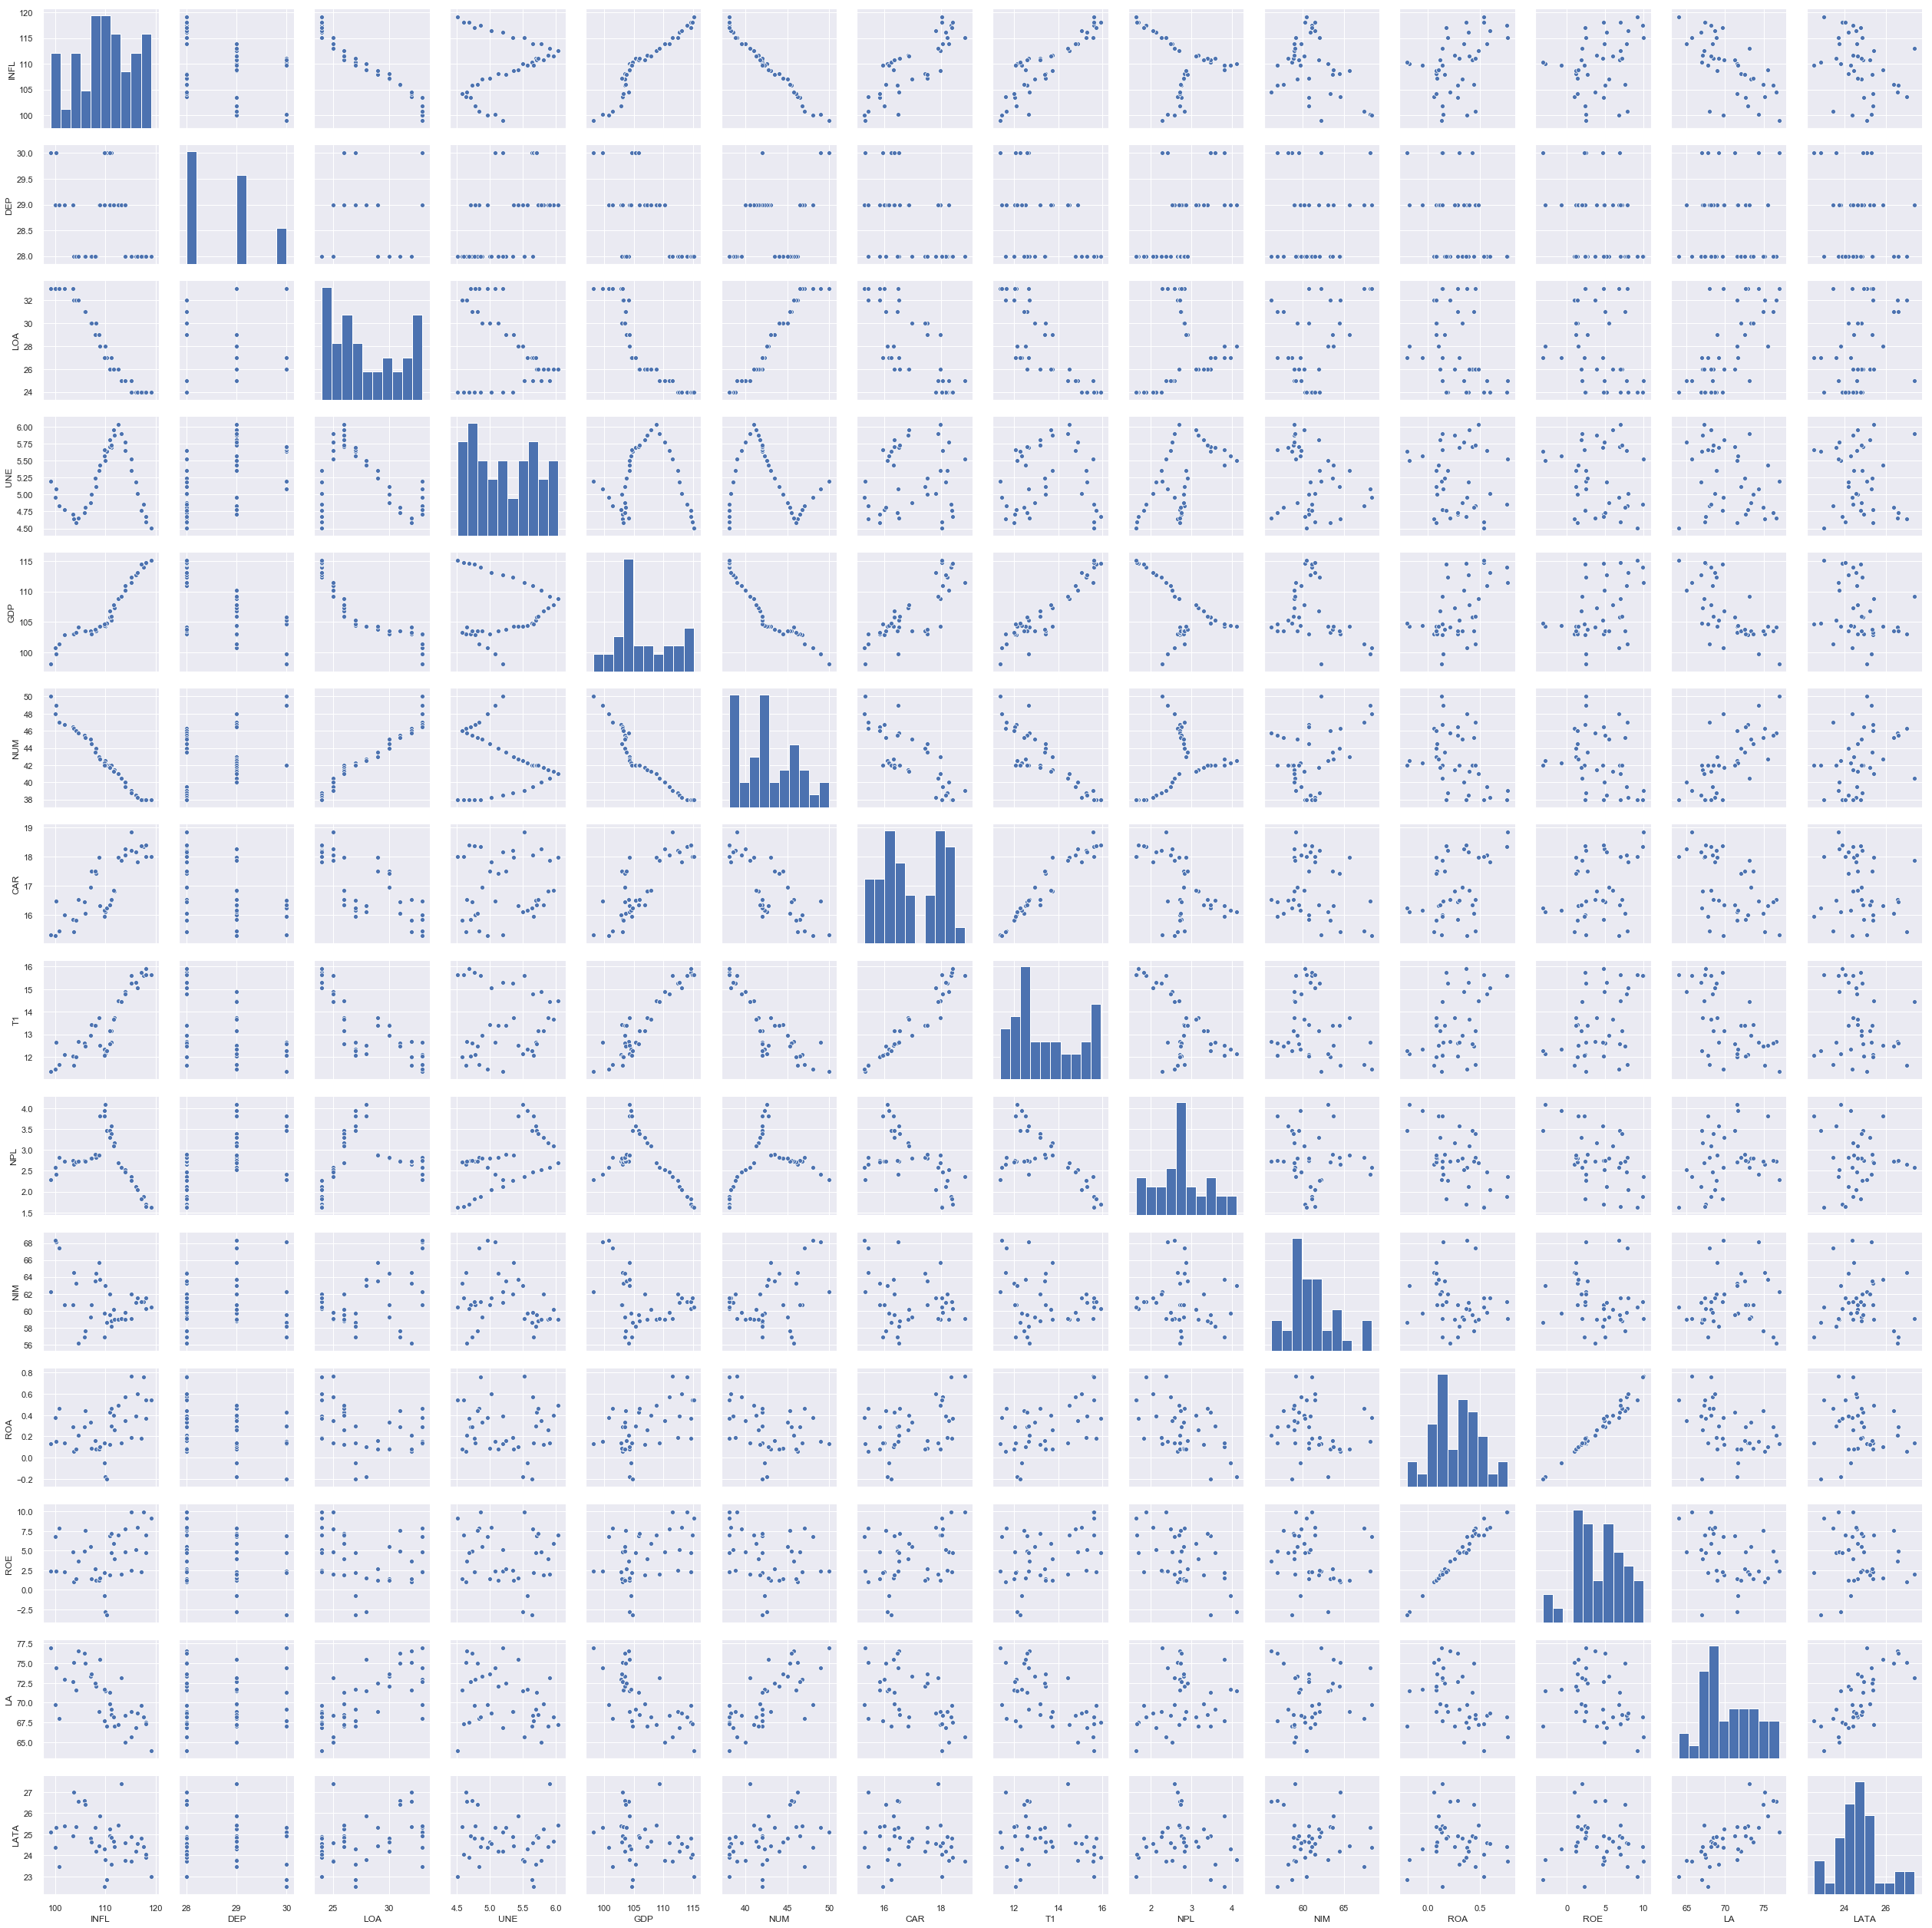

In [5]:
sns.pairplot(austria)


**1.1 Linear regression for NPL**

In [6]:
m1 = ols('NPL ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                    NPL   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     33.66
Date:                Sun, 14 Jun 2020   Prob (F-statistic):           1.05e-12
Time:                        14:22:39   Log-Likelihood:                 1.7516
No. Observations:                  40   AIC:                             10.50
Df Residuals:                      33   BIC:                             22.32
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.8558     14.764      4.054      0.0

Text(0, 0.5, 'Residual $y - \\hat{y}$')

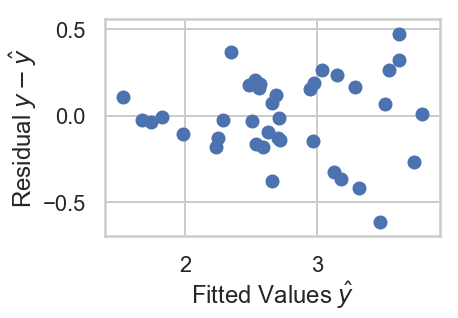

In [75]:
plt.scatter(m1.fittedvalues, m1.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

There is no pattern in the residuals

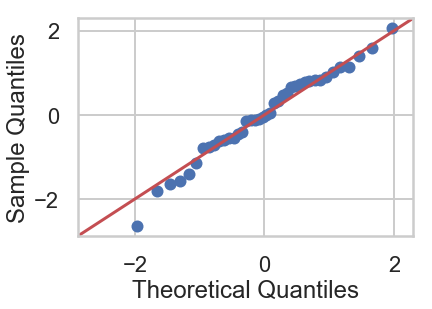

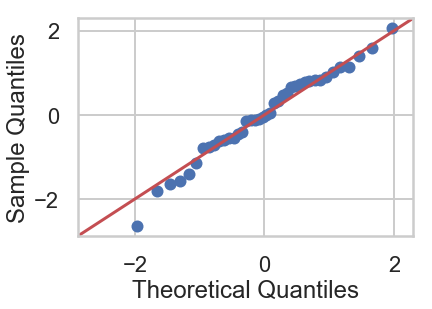

In [76]:
resid = m1.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

Good fit across the quantiles

(array([1., 1., 3., 3., 7., 7., 4., 9., 3., 2.]),
 array([-0.61093176, -0.50223473, -0.39353771, -0.28484068, -0.17614365,
        -0.06744662,  0.0412504 ,  0.14994743,  0.25864446,  0.36734149,
         0.47603851]),
 <a list of 10 Patch objects>)

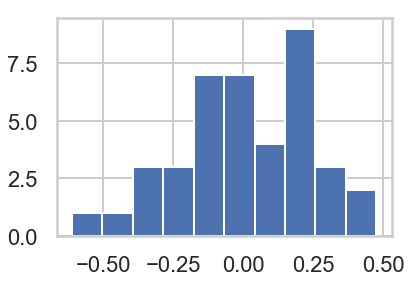

In [104]:
plt.hist(m1.resid)

residuals are all around zero value

**1.2. Lasso regression for NPLs using Statsmodels**

In [80]:
m1_reg = ols('NPL ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [81]:
print('Parameters: ', m1_reg.params)

Parameters:  Intercept    0.000000
UNE          0.000000
GDP          0.016392
INFL         0.002163
DEP          0.000000
LOA          0.011115
NUM          0.010612
dtype: float64


There are only 4 independent variables left: GDP, INFL, LOA and NUM

**1.3. Lasso regression for NPL using Scikit**

In [79]:
austria_NPL = austria.drop(['Date', 'T1', 'CAR', 'NIM', 'ROA', 'ROE', 'LA', 'LATA'], axis=1)

print(austria_NPL.head())

         INFL   DEP   LOA   UNE         GDP    NUM   NPL
0   99.048490  30.0  33.0  5.20   98.140928  50.00  2.28
1  100.175077  30.0  33.0  5.08   99.765166  49.00  2.41
2  100.053286  29.0  33.0  4.96  100.721266  48.00  2.58
3  100.723147  29.0  33.0  4.84  101.372640  47.00  2.83
4  101.894533  29.0  33.0  4.78  102.847952  46.75  2.72


In [66]:
X= austria_NPL.drop('NPL',axis=1).values
y= austria_NPL['NPL'].values
names = austria_NPL.drop('NPL', axis=1).columns

In [60]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)


In [61]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.5850461389595465
test score:  0.6365560675912512
number of features used:  3


Relatively weak test score at 0.63

In [62]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[-22.95383444 -26.13433824 -19.42001021   0.55727085 -30.41917306]


In [ ]:
Very weak cross-validation results, could be because of small sample

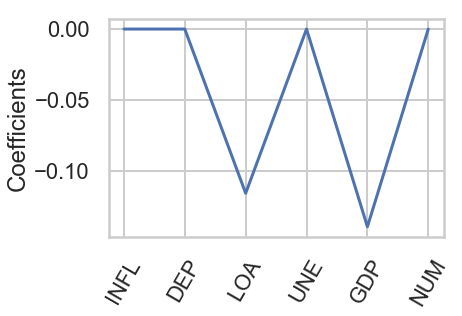

In [67]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

**2.1. Linear regression for T1**

In [41]:
m2 = ols('T1 ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                     T1   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     55.85
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           7.06e-16
Time:                        15:32:48   Log-Likelihood:                -21.997
No. Observations:                  40   AIC:                             57.99
Df Residuals:                      33   BIC:                             69.82
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.0414     26.733     -2.807      0.0

Text(0, 0.5, 'Residual $y - \\hat{y}$')

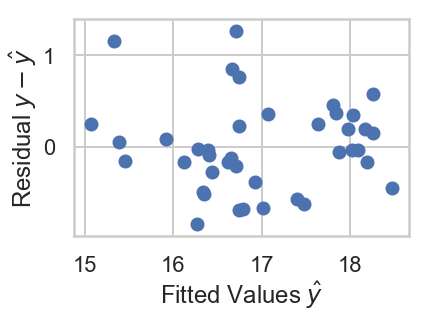

In [83]:
plt.scatter(m2.fittedvalues, m2.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

No clear pattern, looks like randomly distributed

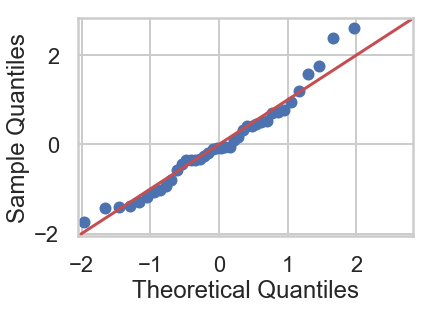

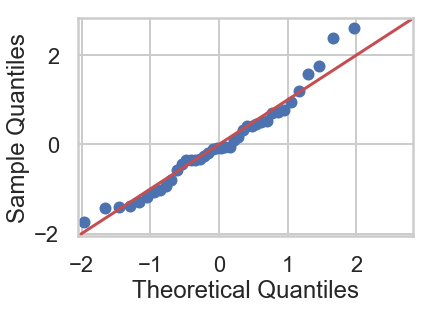

In [84]:
resid = m2.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

There seems to be an issue in the highest quantiles

(array([ 4.,  5.,  2., 12.,  5.,  6.,  2.,  1.,  1.,  2.]),
 array([-0.84762596, -0.63634872, -0.42507149, -0.21379425, -0.00251702,
         0.20876022,  0.42003746,  0.63131469,  0.84259193,  1.05386916,
         1.2651464 ]),
 <a list of 10 Patch objects>)

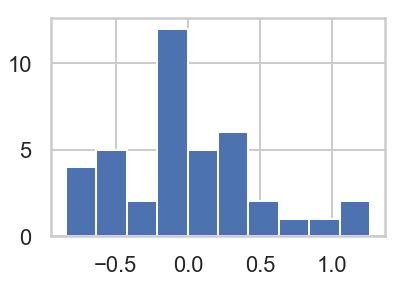

In [103]:
plt.hist(m2.resid)

Histogram does not show a normal distribution around 0

**2.2. Lasso regression for T1 using Statsmodels**

In [86]:
m2_reg = ols('T1 ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [88]:
print('Parameters: ', m2_reg.params)

Parameters:  Intercept    0.000000
UNE          0.499931
GDP          0.126073
INFL         0.000000
DEP         -0.024334
LOA         -0.068296
NUM          0.000000
dtype: float64


Strong performance of UNE and GDP

**2.3 Lasso regression for T1 using Scikit**

In [90]:
austria_T1 = austria.drop(['Date', 'NPL', 'CAR', 'NIM', 'ROA', 'ROE', 'LA', 'LATA'], axis=1)

print(austria_T1.head())

         INFL   DEP   LOA   UNE         GDP    NUM     T1
0   99.048490  30.0  33.0  5.20   98.140928  50.00  11.36
1  100.175077  30.0  33.0  5.08   99.765166  49.00  12.65
2  100.053286  29.0  33.0  4.96  100.721266  48.00  11.44
3  100.723147  29.0  33.0  4.84  101.372640  47.00  11.65
4  101.894533  29.0  33.0  4.78  102.847952  46.75  12.10


In [91]:
X= austria_T1.drop('T1',axis=1).values
y= austria_T1['T1'].values
names = austria_T1.drop('T1', axis=1).columns

In [92]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [93]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.8880087836956014
test score:  0.8303183002743172
number of features used:  1


Good trainign score, but weaker test score

In [94]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[ -1.40214237  -2.12100465 -16.35462385   0.63516964   0.29195186]


Weak corssvalidation results

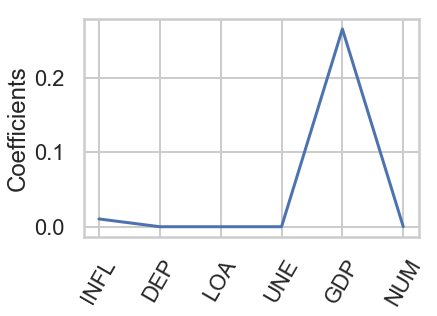

In [95]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

Strong performance of GDP

**3.1. Linear regression for CAR**

In [113]:
m3 = ols('CAR ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     18.87
Date:                Sun, 14 Jun 2020   Prob (F-statistic):           2.17e-09
Time:                        17:15:33   Log-Likelihood:                -27.856
No. Observations:                  40   AIC:                             69.71
Df Residuals:                      33   BIC:                             81.53
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -54.5370     30.949     -1.762      0.0

Text(0, 0.5, 'Residual $y - \\hat{y}$')

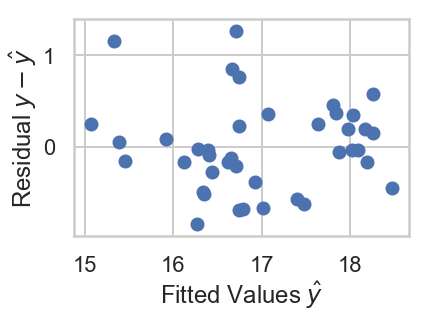

In [97]:
plt.scatter(m3.fittedvalues, m3.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

No clear pattern, looks like random

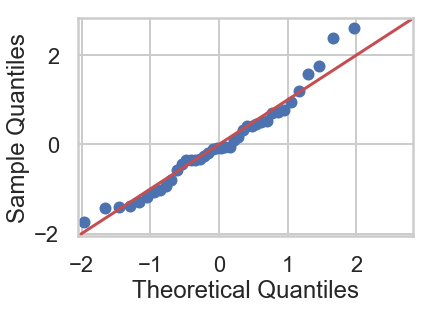

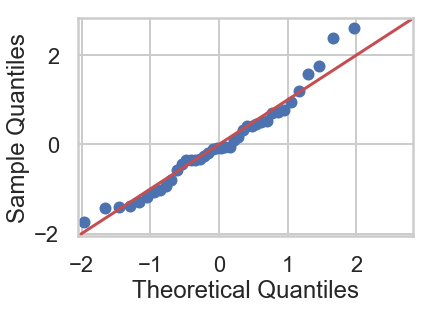

In [98]:
resid = m3.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

Good performance, but some deviation in the higher quantiles

(array([ 4.,  5.,  2., 12.,  5.,  6.,  2.,  1.,  1.,  2.]),
 array([-0.84762596, -0.63634872, -0.42507149, -0.21379425, -0.00251702,
         0.20876022,  0.42003746,  0.63131469,  0.84259193,  1.05386916,
         1.2651464 ]),
 <a list of 10 Patch objects>)

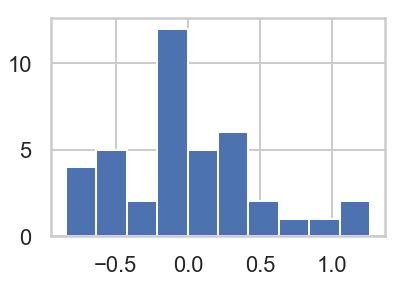

In [102]:
plt.hist(m3.resid)

Histogram does not show a normal distribution around 0

**3.2. Lasso regression for CAR using Statsmodels**

In [105]:
m3_reg = ols('CAR ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [106]:
print('Parameters: ', m3_reg.params)

Parameters:  Intercept    0.000000
UNE          0.797361
GDP          0.120488
INFL         0.000000
DEP          0.000000
LOA         -0.000945
NUM          0.000000
dtype: float64


Strong performance of UNE, partial by GDP

**3.3 Lasso regression for CAR using Scikit**

In [107]:
austria_CAR = austria.drop(['Date', 'NPL', 'T1', 'NIM', 'ROA', 'ROE', 'LA', 'LATA'], axis=1)

print(austria_CAR.head())

         INFL   DEP   LOA   UNE         GDP    NUM    CAR
0   99.048490  30.0  33.0  5.20   98.140928  50.00  15.32
1  100.175077  30.0  33.0  5.08   99.765166  49.00  16.49
2  100.053286  29.0  33.0  4.96  100.721266  48.00  15.30
3  100.723147  29.0  33.0  4.84  101.372640  47.00  15.44
4  101.894533  29.0  33.0  4.78  102.847952  46.75  16.00


In [108]:
X= austria_CAR.drop('CAR',axis=1).values
y= austria_CAR['CAR'].values
names = austria_CAR.drop('CAR', axis=1).columns

In [109]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [110]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.7506737110892827
test score:  0.48889625175966633
number of features used:  2


relatively good training score, but very weak test score

In [111]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[ -2.84932238  -1.89507311 -25.82351272   0.31499397  -1.28551097]


Weak crossvalidation results

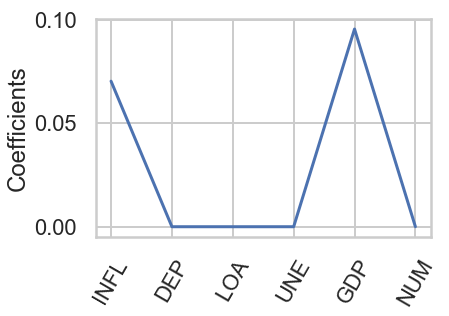

In [112]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

**4.1. Linear regression for NIM**

In [114]:
m4 = ols('NIM ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m4.summary())

                            OLS Regression Results                            
Dep. Variable:                    NIM   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1.902
Date:                Sun, 14 Jun 2020   Prob (F-statistic):              0.110
Time:                        17:19:39   Log-Likelihood:                -93.284
No. Observations:                  40   AIC:                             200.6
Df Residuals:                      33   BIC:                             212.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    327.7801    158.864      2.063      0.0

Text(0, 0.5, 'Residual $y - \\hat{y}$')

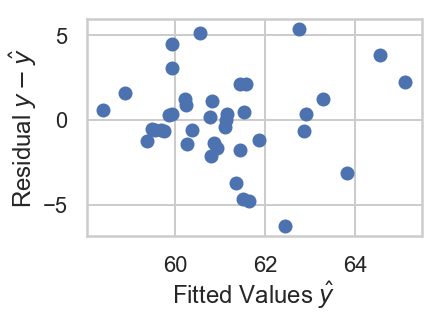

In [115]:
plt.scatter(m4.fittedvalues, m4.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

No clear pattern

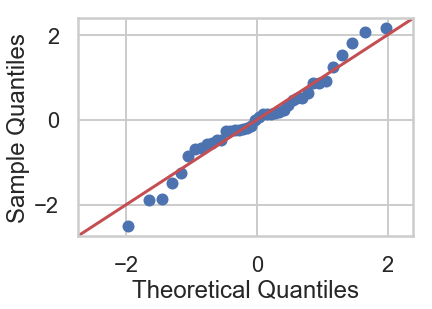

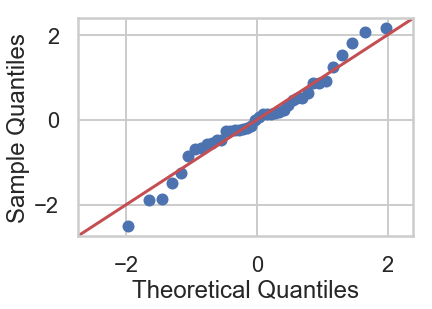

In [116]:
resid = m4.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

Problem in lowest and highest quantiles

(array([ 1.,  2.,  2.,  3., 10.,  9.,  5.,  3.,  2.,  3.]),
 array([-6.24115418, -5.0805418 , -3.91992943, -2.75931705, -1.59870467,
        -0.4380923 ,  0.72252008,  1.88313246,  3.04374483,  4.20435721,
         5.36496959]),
 <a list of 10 Patch objects>)

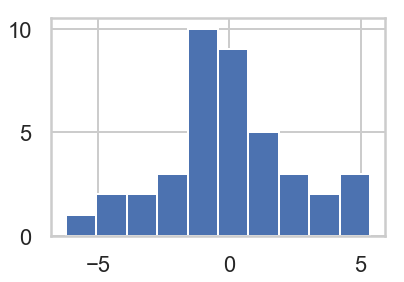

In [117]:
plt.hist(m4.resid)

Almost normal distribution around zero

**4.2. Lasso regression for NIM using Statsmodels**

In [118]:
m4_reg = ols('NIM ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [119]:
print('Parameters: ', m4_reg.params)

Parameters:  Intercept    4.524967
UNE          6.066688
GDP          0.151470
INFL        -0.004990
DEP          0.005705
LOA          0.332400
NUM          0.000000
dtype: float64


Very strong impact of UNE

**4.3 Lasso regression for NIM using Scikit**

In [120]:
austria_NIM = austria.drop(['Date', 'NPL', 'T1', 'CAR', 'ROA', 'ROE', 'LA', 'LATA'], axis=1)

print(austria_NIM.head())

         INFL   DEP   LOA   UNE         GDP    NUM    NIM
0   99.048490  30.0  33.0  5.20   98.140928  50.00  62.23
1  100.175077  30.0  33.0  5.08   99.765166  49.00  68.12
2  100.053286  29.0  33.0  4.96  100.721266  48.00  68.36
3  100.723147  29.0  33.0  4.84  101.372640  47.00  67.37
4  101.894533  29.0  33.0  4.78  102.847952  46.75  60.69


In [122]:
X= austria_NIM.drop('NIM',axis=1).values
y= austria_NIM['NIM'].values
names = austria_NIM.drop('NIM', axis=1).columns

In [123]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [124]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.26964665692630296
test score:  -0.1072583601577255
number of features used:  2


Very weak test score

In [125]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[ -5.47568796  -0.92622369  -0.71238578  -1.27524482 -56.97033088]


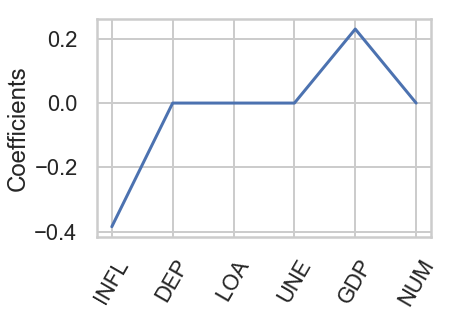

In [126]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

**5.1. Linear regression for ROA**

In [129]:
m5 = ols('ROA ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m5.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     3.902
Date:                Sun, 14 Jun 2020   Prob (F-statistic):            0.00470
Time:                        17:40:13   Log-Likelihood:                 14.382
No. Observations:                  40   AIC:                            -14.76
Df Residuals:                      33   BIC:                            -2.942
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.6554     10.766     -1.454      0.1

Text(0, 0.5, 'Residual $y - \\hat{y}$')

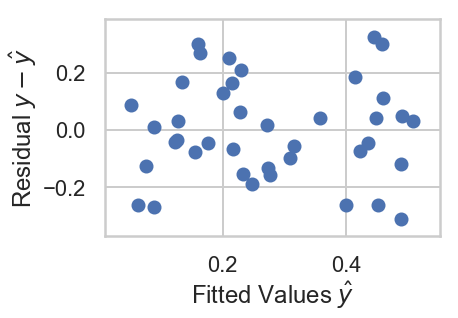

In [130]:
plt.scatter(m5.fittedvalues, m5.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

No clear pattern

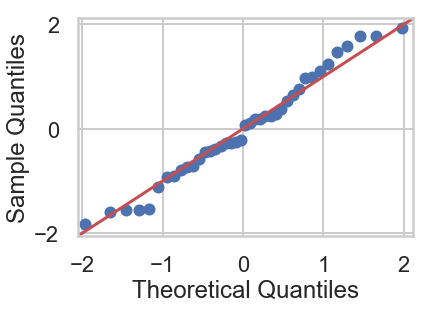

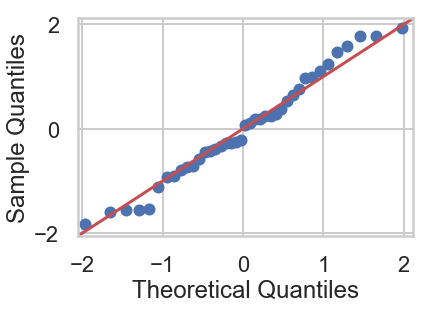

In [131]:
resid = m5.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

Some mismatch in highest and lowest quantiles

(array([5., 1., 5., 5., 4., 8., 3., 3., 2., 4.]),
 array([-0.30920149, -0.24576172, -0.18232195, -0.11888218, -0.0554424 ,
         0.00799737,  0.07143714,  0.13487691,  0.19831668,  0.26175645,
         0.32519622]),
 <a list of 10 Patch objects>)

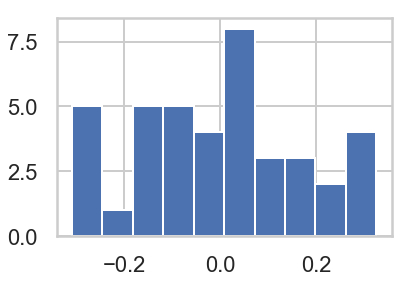

In [132]:
plt.hist(m5.resid)

Almost univariate distribution

**5.2. Lasso regression for ROA using Statsmodels**

In [134]:
m5_reg = ols('ROA ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [135]:
print('Parameters: ', m5_reg.params)

Parameters:  Intercept    0.000000
UNE          0.000000
GDP          0.002543
INFL         0.000000
DEP          0.000000
LOA          0.000000
NUM          0.000000
dtype: float64


Almost no independent variable is significant

**5.3 Lasso regression for ROA using Scikit**

In [136]:
austria_ROA = austria.drop(['Date', 'NPL', 'T1', 'CAR', 'NIM', 'ROE', 'LA', 'LATA'], axis=1)

print(austria_ROA.head())

         INFL   DEP   LOA   UNE         GDP    NUM   ROA
0   99.048490  30.0  33.0  5.20   98.140928  50.00  0.13
1  100.175077  30.0  33.0  5.08   99.765166  49.00  0.15
2  100.053286  29.0  33.0  4.96  100.721266  48.00  0.38
3  100.723147  29.0  33.0  4.84  101.372640  47.00  0.46
4  101.894533  29.0  33.0  4.78  102.847952  46.75  0.14


In [137]:
X= austria_ROA.drop('ROA',axis=1).values
y= austria_ROA['ROA'].values
names = austria_ROA.drop('ROA', axis=1).columns

In [138]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [139]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.1951598284691302
test score:  0.16130835330631343
number of features used:  1


Very weak score

In [175]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[-2.24262816 -0.37103466 -0.59838097 -0.31552703 -1.03239721]


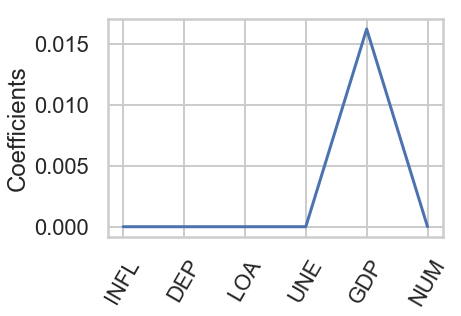

In [140]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

**6.1. Linear regression for ROE**

In [141]:
m6 = ols('ROE ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m6.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     2.778
Date:                Sun, 14 Jun 2020   Prob (F-statistic):             0.0268
Time:                        17:57:20   Log-Likelihood:                -94.695
No. Observations:                  40   AIC:                             203.4
Df Residuals:                      33   BIC:                             215.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -242.0150    164.568     -1.471      0.1

Text(0, 0.5, 'Residual $y - \\hat{y}$')

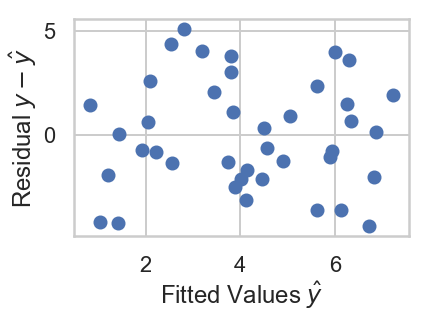

In [142]:
plt.scatter(m6.fittedvalues, m6.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

There could be some correlation in the area of values between 4 and 6

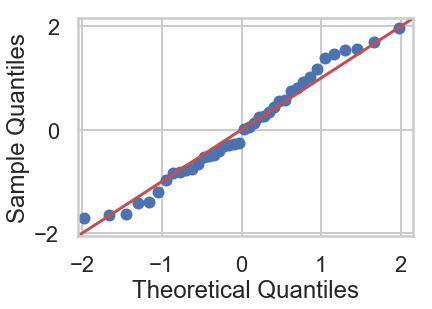

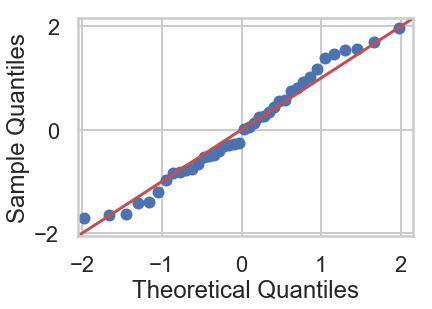

In [143]:
resid = m6.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

Some mismatch in highest and lowest quantiles

(array([5., 2., 5., 8., 3., 4., 4., 3., 4., 2.]),
 array([-4.3831511 , -3.43660427, -2.49005743, -1.5435106 , -0.59696376,
         0.34958307,  1.2961299 ,  2.24267674,  3.18922357,  4.13577041,
         5.08231724]),
 <a list of 10 Patch objects>)

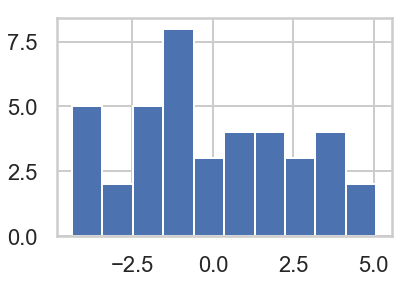

In [144]:
plt.hist(m6.resid)

Not a normal distributions

**6.2. Lasso regression for ROE using Statsmodels**

In [145]:
m6_reg = ols('ROE ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [146]:
print('Parameters: ', m6_reg.params)

Parameters:  Intercept    0.000000
UNE          0.000000
GDP          0.064190
INFL         0.000000
DEP         -0.035042
LOA         -0.061389
NUM          0.000000
dtype: float64


Only 3 variables left GDP, DEP and LOA

**6.3 Lasso regression for ROA using Scikit**

In [147]:
austria_ROE = austria.drop(['Date', 'NPL', 'T1', 'CAR', 'NIM', 'ROA', 'LA', 'LATA'], axis=1)

print(austria_ROE.head())

         INFL   DEP   LOA   UNE         GDP    NUM   ROE
0   99.048490  30.0  33.0  5.20   98.140928  50.00  2.44
1  100.175077  30.0  33.0  5.08   99.765166  49.00  2.44
2  100.053286  29.0  33.0  4.96  100.721266  48.00  6.82
3  100.723147  29.0  33.0  4.84  101.372640  47.00  7.89
4  101.894533  29.0  33.0  4.78  102.847952  46.75  2.34


In [148]:
X= austria_ROE.drop('ROE',axis=1).values
y= austria_ROE['ROE'].values
names = austria_ROE.drop('ROE', axis=1).columns

In [149]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [150]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.2141548921619677
test score:  0.27521102625874233
number of features used:  2


Very weak score

In [176]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[-2.24262816 -0.37103466 -0.59838097 -0.31552703 -1.03239721]


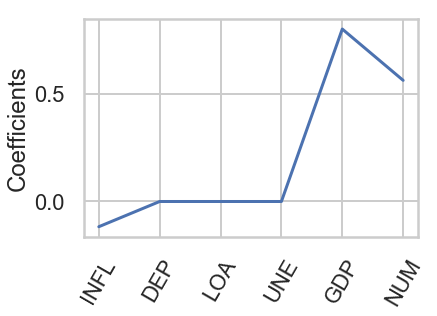

In [151]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

**7.1. Linear regression for LA**

In [152]:
m7 = ols('LA ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m7.summary())

                            OLS Regression Results                            
Dep. Variable:                     LA   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     8.933
Date:                Sun, 14 Jun 2020   Prob (F-statistic):           8.12e-06
Time:                        18:12:35   Log-Likelihood:                -85.881
No. Observations:                  40   AIC:                             185.8
Df Residuals:                      33   BIC:                             197.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.1305    132.025      0.902      0.3

Text(0, 0.5, 'Residual $y - \\hat{y}$')

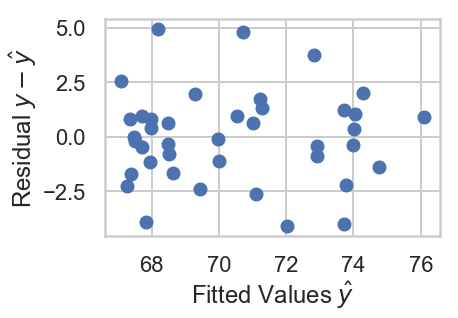

In [153]:
plt.scatter(m7.fittedvalues, m7.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

Seems like a random distribution

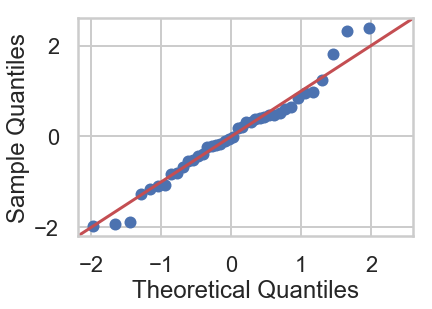

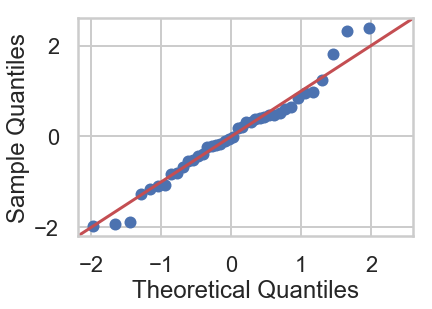

In [154]:
resid = m7.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

Weak performance in lowest and highest quantiles

(array([3., 2., 5., 4., 9., 9., 4., 1., 1., 2.]),
 array([-4.07952405, -3.1779377 , -2.27635135, -1.374765  , -0.47317865,
         0.42840769,  1.32999404,  2.23158039,  3.13316674,  4.03475309,
         4.93633944]),
 <a list of 10 Patch objects>)

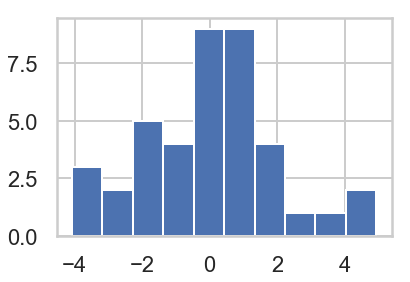

In [155]:
plt.hist(m7.resid)

Almost normal distribution

**7.2. Lasso regression for LA using Statsmodels**

In [156]:
m7_reg = ols('LA ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [157]:
print('Parameters: ', m7_reg.params)

Parameters:  Intercept    10.736264
UNE           5.935717
GDP           0.136117
INFL          0.000000
DEP           0.061476
LOA           0.526426
NUM          -0.049144
dtype: float64


Strong impact of UNE

**7.3 Lasso regression for LA using Scikit**

In [158]:
austria_LA = austria.drop(['Date', 'NPL', 'T1', 'CAR', 'NIM', 'ROA', 'ROE', 'LATA'], axis=1)

print(austria_LA.head())

         INFL   DEP   LOA   UNE         GDP    NUM     LA
0   99.048490  30.0  33.0  5.20   98.140928  50.00  77.00
1  100.175077  30.0  33.0  5.08   99.765166  49.00  74.38
2  100.053286  29.0  33.0  4.96  100.721266  48.00  69.71
3  100.723147  29.0  33.0  4.84  101.372640  47.00  67.96
4  101.894533  29.0  33.0  4.78  102.847952  46.75  72.97


In [159]:
X= austria_LA.drop('LA',axis=1).values
y= austria_LA['LA'].values
names = austria_LA.drop('LA', axis=1).columns

In [160]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [161]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.5510645384407601
test score:  0.4784513832101147
number of features used:  4


Solid score, but not enough for the model

In [177]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[-2.24262816 -0.37103466 -0.59838097 -0.31552703 -1.03239721]


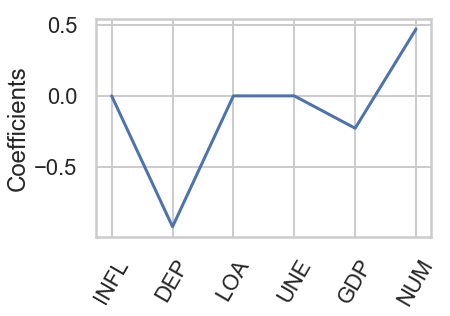

In [162]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

**8.1. Linear regression for LATA**

In [164]:
m8 = ols('LATA ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit()
print(m8.summary())

                            OLS Regression Results                            
Dep. Variable:                   LATA   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     3.854
Date:                Sun, 14 Jun 2020   Prob (F-statistic):            0.00506
Time:                        18:27:52   Log-Likelihood:                -48.689
No. Observations:                  40   AIC:                             111.4
Df Residuals:                      33   BIC:                             123.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1181     52.101     -0.041      0.9

Text(0, 0.5, 'Residual $y - \\hat{y}$')

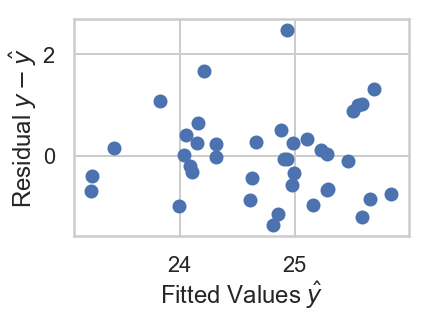

In [165]:
plt.scatter(m8.fittedvalues, m8.resid)
plt.xlabel("Fitted Values $\hat{y}$")
plt.ylabel("Residual $y - \hat{y}$")

Some correlation around the value 25

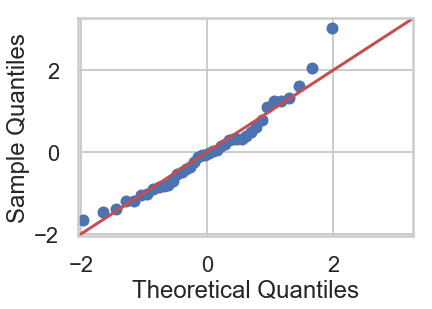

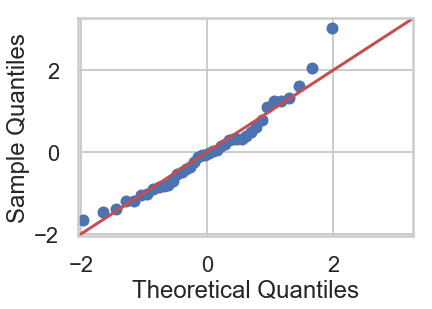

In [166]:
resid = m8.resid
mean = np.mean(resid)
sd = np.std(resid)
z = (resid - mean) / sd
sm.qqplot(z, line='45')

significant undepreformance at hghest quantile

(array([4., 7., 5., 9., 7., 2., 4., 1., 0., 1.]),
 array([-1.36128504, -0.97774248, -0.59419992, -0.21065737,  0.17288519,
         0.55642775,  0.9399703 ,  1.32351286,  1.70705542,  2.09059797,
         2.47414053]),
 <a list of 10 Patch objects>)

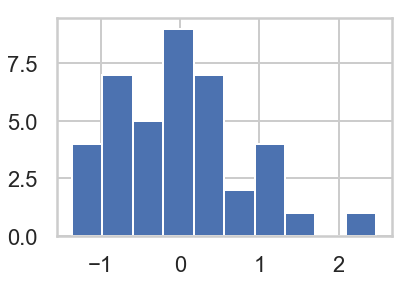

In [167]:
plt.hist(m8.resid)

Somewhat resembles normal distribution

**8.2. Lasso regression for LATA using Statsmodels**

In [168]:
m8_reg = ols('LATA ~ UNE + GDP + INFL + DEP + LOA + NUM',austria).fit_regularized(method='elastic_net', alpha=1, L1_wt=1.0)


In [169]:
print('Parameters: ', m8_reg.params)

Parameters:  Intercept    0.000000
UNE          1.547753
GDP          0.119395
INFL         0.000000
DEP          0.000000
LOA          0.142126
NUM          0.000000
dtype: float64


Some impact of UNE and GDP and LOA

**8.3 Lasso regression for LATA using Scikit**

In [170]:
austria_LATA = austria.drop(['Date', 'NPL', 'T1', 'CAR', 'NIM', 'ROA', 'ROE', 'LA'], axis=1)

print(austria_LATA.head())

         INFL   DEP   LOA   UNE         GDP    NUM   LATA
0   99.048490  30.0  33.0  5.20   98.140928  50.00  25.10
1  100.175077  30.0  33.0  5.08   99.765166  49.00  25.32
2  100.053286  29.0  33.0  4.96  100.721266  48.00  24.38
3  100.723147  29.0  33.0  4.84  101.372640  47.00  23.45
4  101.894533  29.0  33.0  4.78  102.847952  46.75  25.38


In [171]:
X= austria_LATA.drop('LATA',axis=1).values
y= austria_LATA['LATA'].values
names = austria_LATA.drop('LATA', axis=1).columns

In [172]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
lasso = Lasso(alpha=0.2)
lasso_coef = lasso.fit(X, y).coef_
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)

In [173]:
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.04570581368856829
test score:  0.11699446860118701
number of features used:  2


Very weak score

In [178]:
cv_results = cross_val_score(lasso, X, y, cv=5)
print(cv_results)

[-2.24262816 -0.37103466 -0.59838097 -0.31552703 -1.03239721]


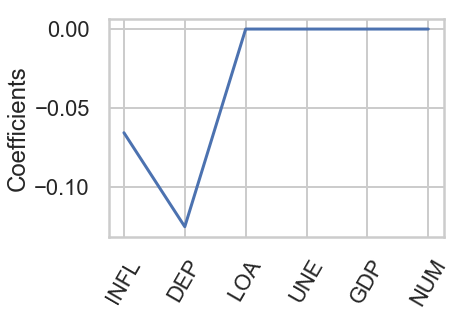

In [179]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()